# Google OR tools for Job shop Problem 

# Summary 

In [4]:
# sum(task[1] for job in jobs_data for task in job)
# Data.
# task = (machine_id, processing_time).
jobs_data = [  
    [(0, 3), (1, 6), (2, 2)],  # Job0
    [(0, 2), (2, 5), (1, 4)],  # Job1
    [(1, 4), (2, 3), (0, 6)]   # Job2
]
jobs_count = len(jobs_data) 
machines_count = 1 + max(task[0] for job in jobs_data for task in job)
machine_seq = [[j[0] for j in i] for i in jobs_data]
process_time = [[j[1] for j in i] for i in jobs_data]

# Import (or include) the OR-Tools linear solver wrapper, 
# an interface for MIP solvers and linear solvers, as shown below.
from ortools.linear_solver import pywraplp


# Import the linear solver wrapper 
# The following code declares the MIP solver for the problem. 
# This example uses the third-party solver SCIP. 
solver = pywraplp.Solver.CreateSolver('SCIP')

big_M =  1e5 # very large number 
# (6)
y = {}
for j in range(jobs_count): 
    for i in range(machines_count):
        y[f'{i}{j}'] = solver.IntVar(0.0, big_M, name=f'y{i}{j}') 
# (7)        
x = {}
for j in range(jobs_count): 
    for l in range(jobs_count): 
        for i in range(machines_count):
            x[f'{i}{j}{l}'] = solver.BoolVar(name=f'x{i}{j}{l}')
            
# (2)
for j in range(jobs_count): 
    for i,m in enumerate(machine_seq[j]):
        if i>=1: 
            y_ij = y[f'{machine_seq[j][i-1]}{j}']
            p_ij = process_time[j][i-1]
            y_kj = y[f'{machine_seq[j][i]}{j}']
            solver.Add(y_kj >= y_ij + p_ij)

# (4), (5)
for j in range(jobs_count): 
    for l in range(jobs_count): 
        for i in range(machines_count):  
            if j<l: 
                y_ij = y[f"{i}{j}"]
                y_il = y[f"{i}{l}"]
                p_ij = process_time[j][machine_seq[j].index(i)]
                p_il = process_time[l][machine_seq[l].index(i)]
                x_ijl = x[f"{i}{j}{l}"]
                solver.Add(y_ij - y_il >= p_il - big_M*x_ijl)
                solver.Add(y_il - y_ij >= p_ij + big_M*(x_ijl-1))
           
# (3)
cmax = solver.IntVar(0.0, solver.Infinity(), name='cmax')
for j in range(jobs_count): 
    y_jm = y[f"{machine_seq[j][-1]}{j}"]
    p_jm = process_time[j][machines_count-1]
    solver.Add(cmax >= y_jm + p_jm)

# (1)
solver.Minimize(cmax)
# solve & solution 
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('Solution:')
    print('Objective value =', solver.Objective().Value())
    for j in range(jobs_count): 
        for i in machine_seq[j]: 
            name =f"{i}{j}" 
            print(f"y{name}= {y[name].solution_value()}")
else:
    print('The problem does not have an optimal solution.')


Solution:
Objective value = 16.0
y00= 2.0
y10= 5.0
y20= 12.0
y01= 0.0
y21= 7.0
y11= 12.0
y12= 0.0
y22= 4.0
y02= 10.0


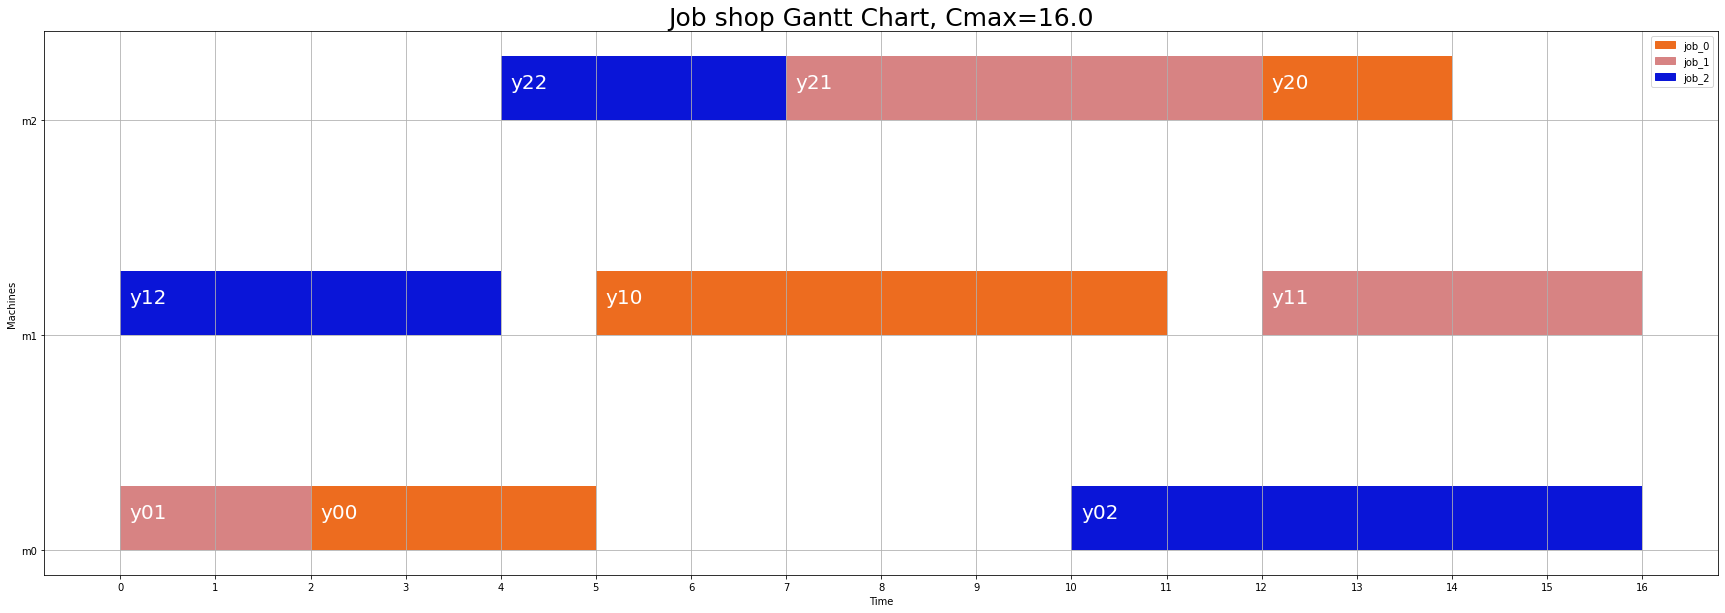

In [5]:
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import numpy as np 

schedule = {m:[] for m in range(machines_count)}
for k,v in y.items(): 
    schedule[int(k[0])].append([f'y{k}', int(v.solution_value()), process_time[int(k[1])][machine_seq[int(k[1])].index(int(k[0]))]])

for k,v in schedule.items(): 
    schedule[k] = sorted(schedule[k], key=lambda x: x[1]) 

job_color = {i:np.random.rand(3,) for i in range(jobs_count)}
fig, gnt = plt.subplots(figsize=(30,10))
gnt.set_title(f"Job shop Gantt Chart, Cmax={solver.Objective().Value()}", fontsize=25)
gnt.grid(True)
gnt.set_xlabel('Time')
gnt.set_ylabel('Machines')

gnt.set_xticks([i for i in range(int(solver.Objective().Value())+1)])
gnt.set_yticks([i for i in range(machines_count)])
gnt.set_yticklabels([f'm{i}' for i in range(machines_count)], fontsize=10)

patch_list = [] 
for i in job_color: 
    patch = mpatches.Patch(color=job_color[i], label=f'job_{i}')
    patch_list.append(patch)
gnt.legend(handles=patch_list)

for m in range(machines_count):
    gnt.broken_barh([(i[1], i[2]) for i in schedule[m]], (m, 0.3), facecolors=[job_color[int(i[0][-1])] for i in schedule[m]])
    for i in schedule[m]:
        gnt.text(i[1]+0.1, m+0.15, i[0], rotation=0, fontsize=20, c='white')